In [1]:
from coffea.nanoevents import NanoEventsFactory, BaseSchema, PFNanoAODSchema
import json
import fastjet
import numpy as np
import awkward as ak
from coffea import processor
import hist
import coffea.nanoevents.methods.vector as vector
import warnings
import matplotlib.pyplot as plt
import math
from variable_functions import *
import os
import dask_awkward as dak
import scipy

/tmp/ipykernel_1784816/3549297373.py:8: FutureWarning: In version 2024.7.0 (target date: 2024-06-30 11:59:59-05:00), this will be an error.
To raise these warnings as errors (and get stack traces to find out where they're called), run
    import warnings
    warnings.filterwarnings("error", module="coffea.*")
after the first `import coffea` or use `@pytest.mark.filterwarnings("error:::coffea.*")` in pytest.
Issue: coffea.nanoevents.methods.vector will be removed and replaced with scikit-hep vector. Nanoevents schemas internal to coffea will be migrated. Otherwise please consider using that package!.
  import coffea.nanoevents.methods.vector as vector


In [2]:
warnings.filterwarnings("ignore", module="coffea.*")
warnings.filterwarnings("ignore", "Found duplicate branch")
warnings.filterwarnings("ignore", "Missing cross-reference index for")
warnings.filterwarnings("ignore", "dcut")
warnings.filterwarnings("ignore", "Please ensure")
warnings.filterwarnings("ignore", "invalid value")

In [4]:
#path = '/project01/ndcms/cmoore24/samples/qcd/470to600/'
path = '/project01/ndcms/cmoore24/samples/flatHbb/mass125/'

In [5]:
files = os.listdir(path)[:1]

In [6]:
events = NanoEventsFactory.from_root(
    [{path + i: "/Events"} for i in files],
    delayed=True,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "Hbb"},
).events()

In [8]:
with open('triggers.json', 'r') as f:
    triggers = json.load(f)

In [9]:
events['PFCands', 'pt'] = (
    events.PFCands.pt
    * events.PFCands.puppiWeight
)

In [10]:
# cut_to_fix_softdrop = (ak.num(events.FatJet.constituents.pf, axis=2) > 0)
# events = events[ak.all(cut_to_fix_softdrop, axis=1)]

In [11]:
goodmuon = (
    (events.Muon.pt > 10)
    & (abs(events.Muon.eta) < 2.4)
    & (events.Muon.pfRelIso04_all < 0.25)
    & events.Muon.looseId
)
nmuons = ak.sum(goodmuon, axis=1)
leadingmuon = ak.firsts(events.Muon[goodmuon])

In [12]:
goodelectron = (
    (events.Electron.pt > 10)
    & (abs(events.Electron.eta) < 2.5)
    & (events.Electron.cutBased >= 2)
)
nelectrons = ak.sum(goodelectron, axis=1)

In [13]:
ntaus = ak.sum(
            (
                (events.Tau.pt > 20)
                & (abs(events.Tau.eta) < 2.3)
                & (events.Tau.rawIso < 5)
                & (events.Tau.idDeepTau2017v2p1VSjet)
                & ak.all(events.Tau.metric_table(events.Muon[goodmuon]) > 0.4, axis=2)
                & ak.all(events.Tau.metric_table(events.Electron[goodelectron]) > 0.4, axis=2)
            ),
            axis=1,
        )

In [14]:
nolepton = (nmuons == 0) & (nelectrons == 0) & (ntaus == 0)

In [15]:
ak.where(nolepton.compute() == False)

(<Array [10, 16, 89, 111, 203, ..., 2976, 2993, 2995, 2997] type='106 * int64'>,)

In [16]:
onemuon = ((nmuons == 1) & (nelectrons == 0) & (ntaus == 0))
muonkin = ((leadingmuon.pt > 55.) & (abs(leadingmuon.eta) < 2.1))
muonDphiAK8 = (abs(leadingmuon.delta_phi(events.FatJet)) > 2*np.pi/3)

In [17]:
# trigger = ak.zeros_like(ak.firsts(events.FatJet.pt), dtype='bool')
# for t in triggers['2017']:
#     if t in events.HLT.fields:
#         trigger = trigger | events.HLT[t]
# trigger = ak.fill_none(trigger, False)

In [25]:
genhiggs.children.pdgId.compute()

<Array [[[21, 21]], [[...]], ..., [[21, 21]]] type='3000 * var * var * ?int...'>

In [18]:
genhiggs = events.GenPart[
    (abs(events.GenPart.pdgId) == 25)
    & events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
]
parents = events.FatJet.nearest(genhiggs, threshold=0.2)
higgs_jets = ~ak.is_none(parents, axis=1)

# events['FatJet', 'num_fatjet'] = ak.num(events.FatJet)

# JetSelect = (
#     (events.Jet.btagDeepFlavB < 0.3040)
# )

# events['Jet'] = events.Jet[JetSelect]

fatjetSelect = (
            (events.FatJet.pt > 400)
            & (abs(events.FatJet.eta) < 2.4)
            & (events.FatJet.msoftdrop > 40)
            & (events.FatJet.msoftdrop < 200)
            #& (trigger)
            & (nolepton)
            # & (higgs_jets)
            & (ak.all(events.FatJet.subjets.btagDeepB < .4506, axis=2))
            #& (ak.all(events.FatJet.subjets.btagDeepB > 0, axis=2))
        )

# events["goodjets"] = events.FatJet[fatjetSelect]
# mask = ~ak.is_none(ak.firsts(events.goodjets))
events["goodjets"] = events.FatJet[fatjetSelect]
mask = ~ak.is_none(ak.firsts(events.goodjets))
events = events[mask]
# cut = (ak.num(uncut_events.FatJet.constituents.pf, axis=2) > 0)
# events = uncut_events[ak.all(cut, axis=1)]

In [17]:
jetdef = fastjet.JetDefinition(
            fastjet.cambridge_algorithm, 0.8
        )
pf = ak.flatten(events.goodjets.constituents.pf, axis=1)
cluster = fastjet.ClusterSequence(pf, jetdef)
softdrop = cluster.exclusive_jets_softdrop_grooming()
softdrop_cluster = fastjet.ClusterSequence(softdrop.constituents, jetdef)

ecfs = {}
for n in range(2,6):
    for v in range(1, int(scipy.special.binom(n, 2))+1):
        for b in range(5, 45, 5):
            ecf_name = f'{v}e{n}^{b/10}'
            ecfs[ecf_name] = ak.unflatten(
                softdrop_cluster.exclusive_jets_energy_correlator(
                    func='generic', npoint=n, angles=v, beta=b/10, normalized=True), 
                counts=ak.num(events.goodjets)
            )   


In [18]:
len(ecfs)

160

In [19]:
path = '/scratch365/cmoore24/training/hgg/batch/outputs_fd/256nodes_3layers_120ecfs_32batch_2msoftdrop/'

with open(f'{path}/selected_ecfs.txt', 'r') as f:
    ratio_list = f.readlines()
ratio_list = [item.strip() for item in ratio_list]

ecf_list = []
for ratio in ratio_list:
    dash = ratio.find('/')
    asterisk = ratio.find('*')
    numerator = ratio[:dash]
    denominator = ratio[dash+1:asterisk]
    ecf_list.append(numerator)
    ecf_list.append(denominator)
ecf_list = list(set(ecf_list))

In [20]:
ecfs = {key: ecfs[key] for key in ecf_list}

In [21]:
len(ecfs)

80

In [22]:
ecfs

{'4e4^2.5': dask.awkward<unflatten, npartitions=1>,
 '10e5^1.0': dask.awkward<unflatten, npartitions=1>,
 '8e5^1.5': dask.awkward<unflatten, npartitions=1>,
 '2e3^4.0': dask.awkward<unflatten, npartitions=1>,
 '3e5^3.0': dask.awkward<unflatten, npartitions=1>,
 '3e4^3.5': dask.awkward<unflatten, npartitions=1>,
 '6e4^0.5': dask.awkward<unflatten, npartitions=1>,
 '4e5^1.0': dask.awkward<unflatten, npartitions=1>,
 '4e4^2.0': dask.awkward<unflatten, npartitions=1>,
 '1e4^2.0': dask.awkward<unflatten, npartitions=1>,
 '3e4^4.0': dask.awkward<unflatten, npartitions=1>,
 '1e3^0.5': dask.awkward<unflatten, npartitions=1>,
 '3e4^3.0': dask.awkward<unflatten, npartitions=1>,
 '3e4^2.0': dask.awkward<unflatten, npartitions=1>,
 '1e4^1.0': dask.awkward<unflatten, npartitions=1>,
 '3e5^3.5': dask.awkward<unflatten, npartitions=1>,
 '6e5^1.5': dask.awkward<unflatten, npartitions=1>,
 '2e5^3.0': dask.awkward<unflatten, npartitions=1>,
 '4e5^3.0': dask.awkward<unflatten, npartitions=1>,
 '4e4^1.5':

In [80]:
ak.where(ak.any(events.goodjets.subjets.btagDeepB.compute() < 0, axis=1) == True)

(<Array [12, 13, 14, 15, 26, 36, ..., 283, 288, 291, 293, 301] type='62 * int64'>,)

In [83]:
a = events.goodjets.compute()[12]

In [97]:
a.btagDeepB_bb

0.00042891502

In [38]:
events.Jet.btagDeepFlavB.__doc__

'DeepJet b+bb+lepb tag discriminator'

In [39]:
events.Jet.btagDeepB.__doc__

'DeepCSV b+bb tag discriminator'

In [22]:
deepjet = events.Jet.btagDeepFlavB

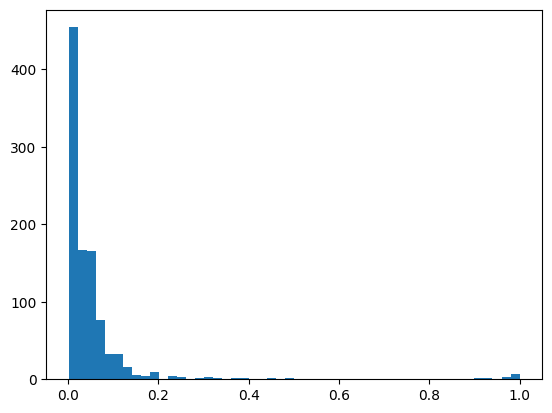

In [23]:
plt.hist(ak.flatten(deepjet), bins=50)
plt.show()

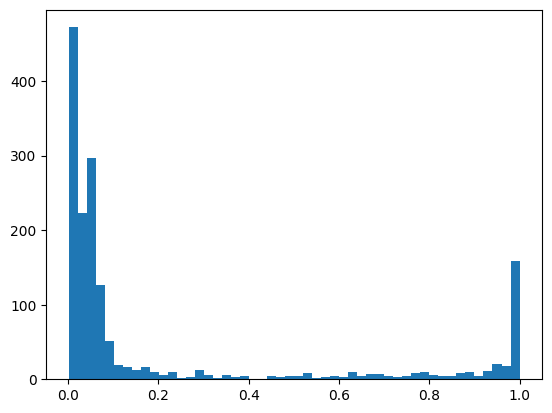

In [22]:
plt.hist(ak.flatten(deepjet), bins=50)
plt.show()

In [35]:
a = events.goodjets[[x for x in ak.fields(events.goodjets) if x == 'area']]

In [36]:
a.compute()

<Array [[{area: 1.96}], [{...}], ..., [{...}]] type='261 * var * {area: flo...'>

In [61]:
events = NanoEventsFactory.from_root(
    {'/project01/ndcms/cmoore24/samples/hbb/' + files[0]: "/Events"},
    delayed=False,
    schemaclass=PFNanoAODSchema,
    metadata={"dataset": "Hbb"},
).events()

In [62]:
events['PFCands', 'pt'] = (
    events.PFCands.pt
    * events.PFCands.puppiWeight
)

In [63]:
cut_to_fix_softdrop = (ak.num(events.FatJet.constituents.pf, axis=2) > 0)
events = events[ak.all(cut_to_fix_softdrop, axis=1)]

In [64]:
genhiggs = events.GenPart[
    (events.GenPart.pdgId == 25)
    & events.GenPart.hasFlags(["fromHardProcess", "isLastCopy"])
]
parents = events.FatJet.nearest(genhiggs, threshold=0.2)
higgs_jets = ~ak.is_none(parents, axis=1)

In [65]:
fatjetSelect = (
            (events.FatJet.pt > 400)
            #& (events.FatJet.num_subjets >= 3)
            & (abs(events.FatJet.eta) < 2.4)
            & (events.FatJet.msoftdrop > 40)
            & (events.FatJet.msoftdrop < 200)
            & (higgs_jets)
        )

In [66]:
events["goodjets"] = events.FatJet[fatjetSelect]

In [67]:
mask = ~ak.is_none(ak.firsts(events.goodjets))

In [68]:
events = events[mask]

In [10]:
a = os.listdir('/project01/ndcms/cmoore24/skims/test/hbb/')[:2]

In [12]:
dak.from_parquet(['/project01/ndcms/cmoore24/skims/test/hbb/' + i for i in a])

dask.awkward<from-parquet, npartitions=2>

In [13]:
a = ak.from_parquet('/project01/ndcms/cmoore24/skims/test/hbb2/')

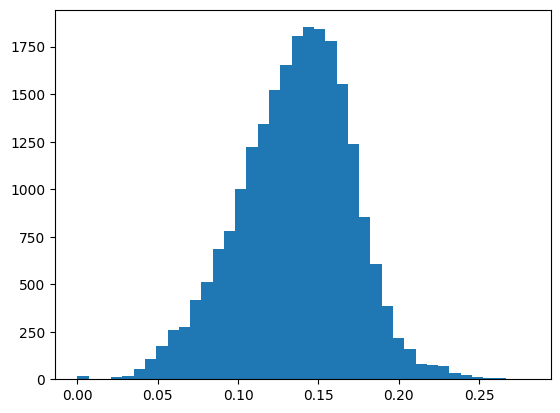

In [24]:
plt.hist(a.goodjets.u1, bins=40)
#plt.yscale('log')
plt.show()

In [20]:
with open('samples_ready.json') as f:
    b = json.load(f)

In [21]:
for i in b:
    print(i)

diboson_ww
diboson_ww4q
diboson_wz
diboson_zz
hbb
hgg
qcd_1000to1400
qcd_1400to1800
qcd_170to300
qcd_1800to2400
qcd_2400to3200
qcd_300to470
qcd_3200toInf
qcd_470to600
qcd_600to800
qcd_800to1000
singletop
ttboosted_1000toInf
ttboosted_700to1000
wqq_200to400
wqq_400to600
wqq_600to800
wqq_800toInf
zqq_200to400
zqq_400to600
zqq_600to800
zqq_800toInf
